<a href="https://colab.research.google.com/github/akemiyamashita/Trainable_Segmentation/blob/master/vgg16_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VGG16を転移学習させて花を分類する

##17floweresのデータを準備する
転移学習のために、University of Oxford, Department of Engineering Science が公開している
[17floweres](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/)からデータセットをダウンロードし、展開する。

実際にはデータ配布元への負荷を避けるために、[githubのリポジトリ](https://github.com/suikan4github/dn_data)から分類済みデータを直接ダウンロードしている。

以下の花のデータは試験用である。自分でクラスわけしたデータを使うときには、このセクションは削除する。データのディレクトリ構造については、[githubのリポジトリ](https://github.com/suikan4github/dn_data)と、[Kerasのマニュアル](https://keras.io/ja/preprocessing/image/#flow_from_directory)を参照。

なお、クラスの文字列ラベルについては、ディレクトリ名から抽出している。

###17flowersのダウンロード

In [0]:
# データを取得して展開する

!wget -c -nc https://github.com/suikan4github/dn_data/raw/master/17flowers.reorg.tgz

!tar -xzf 17flowers.reorg.tgz
!ls

--2018-08-25 07:34:21--  https://github.com/suikan4github/dn_data/raw/master/17flowers.reorg.tgz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/suikan4github/dn_data/master/17flowers.reorg.tgz [following]
--2018-08-25 07:34:22--  https://raw.githubusercontent.com/suikan4github/dn_data/master/17flowers.reorg.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60256544 (57M) [application/octet-stream]
Saving to: ‘17flowers.reorg.tgz’

17flowers.reorg.tgz 100%[===================>]  57.46M  62.9MB/s    in 0.9s    

2018-08-25 07:34:25 (62.9 MB/s) - ‘17flowers.reorg.tgz’ saved [60256

##準備

###モジュールのインポート

In [0]:
import os
import keras
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt


#Jupyterでインライン表示するための宣言
%matplotlib inline 

Using TensorFlow backend.


###パラメタの初期化
各種パラメタをここで初期化する。

各種のイメージ分類に使う場合にはそれぞれのデータが格納されている場所をtrain_data_dir とvalidation_data_dirで指定する。それぞれにはクラス毎に画像データを分けたサブディレクトリをおく。サブディレクトリ名はクラス名になる。学習用とトレーニング用でディレクトリ構造をそろえておくこと。

VGG16に与える引数の詳細は[KerasのVGG16マニュアル](https://keras.io/ja/applications/#vgg16)を参照。

学習の速さや過学習と言った問題に取り組むにはnb_train_step_per_epoch やnb_epochを操作する。

In [0]:
# 学習（訓練）に使うイメージと、学習結果の検証に使うイメージのディレクトリを指定する。
# これらのディレクトリはクラスに対応するサブディレクトリを持ち、サブディレクトリがクラス名になる
# 当然だが、学習用ディレクトリと検証用ディレクトリは同じ名前のサブディレクトリを持たなければならない
# クラスサブディレクトリの中にイメージがおいてある。イメージのサイズは自由。

train_data_dir = 'train_images'
validation_data_dir = 'test_images'

#学習単位であるバッチの大きさ。32から初めて大きくしたり小さくしたり試すとよい。

nb_batch_size = 32

# 内部処理するイメージの大きさ。値は自由だがVGG16を使うので48以上の値にする。
# チャンネル数はRGB3色なので3だが、いずれにせよVGG16を使う以上ここは3固定
# 詳細はKerasのマニュアルを参照 https://keras.io/ja/applications/#vgg16

img_rows, img_cols = 224,224
channels = 3

# 学習に使うイメージの総数を単位として、1エポックでどれだけのイメージを使って学習するかを指定する。
# イメージにはランダムに変形が施されているため、この数を増やすと学習用イメージを増やすのと
# 同じ効果がある

nb_train_step_per_epoch = 8

# エポックの数

nb_epoch = 30

###GPUのメモリ割り当てをオンデマンドにする
GPUのメモリ割り当てを柔軟にするための設定。[Python: Keras/TensorFlow で GPU のメモリを必要な分だけ確保する - CUBE SUGAR CONTAINER](https://blog.amedama.jp/entry/2017/06/07/220723)を参考にした。

いろいろ調査してみた結果としては、性能に与えるインパクトは無視しうる模様。どの程度必要かは不明だが、おまじない程度に。

In [0]:
import tensorflow as tf
from keras.backend import tensorflow_backend


# see https://blog.amedama.jp/entry/2017/06/07/220723
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

##転移学習
VGG16の全結合層を再訓練して新しいデータを学習させる。

パーセプトロン部(全結合層)を捨てているのは、出力のクラス数が元のVGG16と異なるからである。


###学習用のデータジェネレータを作る
train_datagenは個々の写真データにどのような処理を施すかを指示するオブジェクトである。rescale引数は写真の内部のデータを[0,1.0)の区間に正規化するための指示である。Keras本にもこれを使うよう指示されているが、rescaleに関しては、[VGG16におけるKerasの前処理でmeanを引くかどうか - エイバースの中の人](http://blog.livedoor.jp/abars/archives/52428734.html)に、考察があり、それを参考にしてrescaleは行わないことにした。

shear_rangeやholizontal_flipは、画像毎にランダムに施される変形の指定である。こうした変形はnb_steps_per_epochが1の時には特に意味を持たないが、1よりも大きな場合には水増し(data augumentation)として機能するため、元データを増やした場合と同等の効果が期待される。

train_generatorは属性としてclass_indicesを持っており、そのなかにはテキストによるクラス名と対応するクラスインデックスがpythonの辞書データとして格納されている。

ただし、このことはKeras 2.0の[ドキュメント](https://keras.io/preprocessing/image/#flow_from_directory)には明確には書かれていない(2018/Jul)。以下のブログを参考にした。
[A thing you should know about Keras if you plan to train a deep learning model on a large dataset](https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2)

class_indicesの長さから、クラスの数nb_classesを知ることができる。

なお、nb_classesは、あとでパーセプトロンを作るときの出力数の指定するときに必要になる。




In [0]:
# VGG16を使うための画像前処理を適用する
train_datagen =  keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=nb_batch_size,
    shuffle=False)

# クラスの数
nb_classes = len(train_generator.class_indices)

Found 1190 images belonging to 17 classes.


###バリデーション用のデータジェネレータを作る
学習用のジェネレータと同じ手順で抽出するが、データに変形を施していない。検証データを水増ししても意味が無いと思われるからである。水増しを行いたい場合は[ImageDataGenerator](https://keras.io/ja/preprocessing/image/#imagedatagenerator)に変形用のパラメータを与え、nb_val_step_per_epochに1より大きな値を与える。


また、classの数は当然ながら学習用と同じである。


In [0]:
test_datagen =  keras.preprocessing.image.ImageDataGenerator(
    )

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=nb_batch_size,
    shuffle=False)


Found 170 images belonging to 17 classes.


###VGG16を元にネットワークを作る

In [0]:
# VGG16モデルと学習済み重みをロード
# パーセプトロン部(Fully-connected層)はいらないのでinclude_top=False）
input_tensor = keras.layers.Input(shape=(img_rows, img_cols, 3))
model_feature = keras.applications.vgg16.VGG16(
                  include_top=False, 
                  weights='imagenet', 
                  input_tensor=input_tensor)
# model_feature.summary()

# 最後の畳み込み層を除く全ての畳み込み層をフリーズする
#for layer in model_feature.layers[:15]:
#    layer.trainable = False

# 転移学習をするときには、畳込み層を全てフリーズする
for layer in model_feature.layers:
    layer.trainable = False

# パーセプトロン部の作成
model_perceptron = keras.models.Sequential()
model_perceptron.add(keras.layers.Flatten(input_shape=model_feature.output_shape[1:]))
model_perceptron.add(keras.layers.Dense(256, activation='relu'))
model_perceptron.add(keras.layers.Dropout(0.5))
model_perceptron.add(keras.layers.Dense(
                      nb_classes, 
                      activation='softmax'))


# VGG16とパーセプトロンを接続する
model = keras.models.Model(inputs=model_feature.input, outputs=model_perceptron(model_feature.output))

# ネットワークを作ったら必ずコンパイルする
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


58892288/58889256 [==============================] - 12s 0us/step


###ネットワークに学習をさせる
fit_generatorはtrain_generatorからクラスの数や学習サンプルに対応する教師データを取得している。

In [0]:
# Fine-tuning
train_result = model.fit_generator(
      train_generator,
      steps_per_epoch = nb_train_step_per_epoch * len(train_generator),
      epochs = nb_epoch,
      validation_data = validation_generator,
      verbose=1)

model.save_weights("weight_fine_tuning_"+str(nb_classes)+"classes.hdf5")

Epoch 1/30
304/304 [==============================] - 180s 593ms/step - loss: 12.8676 - acc: 0.1777 - val_loss: 8.5304 - val_acc: 0.4118
Epoch 2/30
 73/304 [======>.......................] - ETA: 2:10 - loss: 9.9953 - acc: 0.3345

KeyboardInterrupt: ignored

###学習の推移を描画する
学習結果がエポック毎にどうかわっていくかを描画する。

学習履歴はオブジェクトとしてfit()関数が返すので辞書機能を使って目的のデータ列を取り出している。例えば、train_result.hisotory["acc"]は精度の推移を示リスト。

描画は[Matplotlib](https://matplotlib.org/)の機能を使っている。以下のプログラムのfig変数は[matplotlib.figure.Figure](https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure)型。axes変数は[matplotlib.axes.Axes](https://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes)型。

****************** Summary of Training *****************
Input size                 :  224 * 224
Classes                    :  17
Samples for training       :  1190
Batch size                 :  32
Training steps in an epoch :  8
Epochs                     :  30


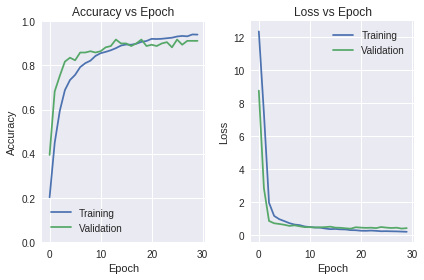

In [0]:
print( "****************** Summary of Training *****************")
print( "Input size                 : ", img_rows,"*",img_cols)
print( "Classes                    : ", nb_classes)
print( "Samples for training       : ", train_generator.classes.shape[0])
print( "Batch size                 : ", nb_batch_size)
print( "Training steps in an epoch : ", nb_train_step_per_epoch)
print( "Epochs                     : ", nb_epoch)

# １行２列のプロット画面を用意する
# figが画面。axesは画面の中のグラフのリスト
fig, axes = plt.subplots(1,2)

# 左側図形にエポック毎の精度の推移を描画する
axes[0].set_title("Accuracy vs Epoch")
axes[0].plot(train_result.history["acc"], label="Training")
axes[0].plot(train_result.history["val_acc"], label="Validation")
axes[0].set_ylim(0,1)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# 右側図形にエポック毎のロスの推移を描画する
axes[1].set_title("Loss vs Epoch")
axes[1].plot(train_result.history["loss"], label="Training")
axes[1].plot(train_result.history["val_loss"], label="Validation")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

# subplotを綺麗に表示するためのまじない
fig.tight_layout()

##学習結果を試験するための準備
自分で用意した画像を表示し、認識結果を人間が読める形で出力する。

###クラス辞書の逆引き化
train_generatorは属性としてclass_indicesを持っており、そのなかにはテキストによるクラス名と対応するクラスインデックスがpythonの辞書データとして格納されている。

ただし、このことはKeras 2.0の[ドキュメント](https://keras.io/preprocessing/image/#flow_from_directory)には明確には書かれていない(2018/Jul)。以下のブログを参考にした。
[A thing you should know about Keras if you plan to train a deep learning model on a large dataset](https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2)


In [0]:
# 表示用のクラス辞書は、flow_from_fileジェネレータのclass_indicesから取得できる。
# ただしこの辞書は文字列型クラス名がキーで、ラベルのインデックスが値である。
class_dict = train_generator.class_indices

# 必要なのはインデックスからクラス名を引く機能なので逆引き辞書を作る
inv_class_dict = {v:k for k, v in class_dict.items()}

###画像認識関数の宣言

In [0]:
def predict_picture(img_path):
  # 画像を指定パスからロードする。
  # 同時にネットワークが受け付けることのできる形にリサイズする。
  img = keras.preprocessing.image.load_img(img_path, target_size=(img_cols, img_rows))

  # 対象画像を表示
  plt.imshow(np.array(img))
  ax = plt.gca()
  ax.grid(color='w', linestyle='none')


  # 画像numpy配列に変換し、さらに4次元テンソルへ変換
  x = keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  # VGG16用の前処理。中でごにょごにょしている。
  x = keras.applications.vgg16.preprocess_input(x)

  # クラスを予測
  # pred()は実は複数枚うけとって、複数の結果を返す。
  # 入力は1枚の画像を含む4次元テンソルなので、出力から[0]のみとりだす。
  pred = model.predict(x)[0]

  # 予測確率が高いトップ5を出力
  top = 5
  top_indices = pred.argsort()[-top:][::-1]
  result = [(inv_class_dict[i], pred[i]) for i in top_indices]
  for x in result:
      print(x)

##画像を認識する

###認識テスト用データの取得


In [0]:
!wget -c -nc "https://github.com/suikan4github/dn_data/raw/master/test.tgz"
!tar -xzf test.tgz

--2018-08-01 05:18:59--  https://github.com/suikan4github/dn_data/raw/master/test.tgz
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/suikan4github/dn_data/master/test.tgz [following]
--2018-08-01 05:19:00--  https://raw.githubusercontent.com/suikan4github/dn_data/master/test.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1010823 (987K) [application/octet-stream]
Saving to: ‘test.tgz’

test.tgz            100%[===================>] 987.13K  --.-KB/s    in 0.07s   

2018-08-01 05:19:00 (13.2 MB/s) - ‘test.tgz’ saved [1010823/1010823]



###認識テスト

('Daisy', 1.0)
('Sunflower', 1.4522546e-19)
('Windflower', 1.0883521e-35)
('Dandelion', 0.0)
('Buttercup', 0.0)


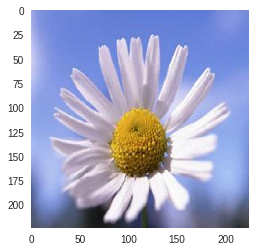

In [0]:
predict_picture('test/daisy.jpg')

('Iris', 1.0)
('LilyValley', 6.7002254e-12)
('Daffodil', 1.1682018e-12)
('Bluebell', 4.7447566e-17)
('Cowslip', 4.6696996e-17)


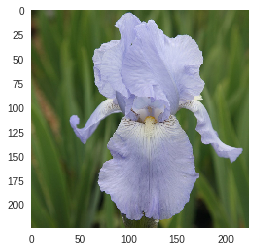

In [0]:
predict_picture('test/iris.jpg')

('Sunflower', 0.67447925)
('Daisy', 0.32540622)
('Pansy', 6.0693837e-05)
('ColtsFoot', 2.263227e-05)
('Dandelion', 1.5401973e-05)


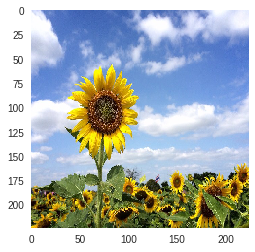

In [0]:
predict_picture('test/sunflower.jpg')


('Tigerlily', 1.0)
('Fritillary', 2.2507019e-13)
('Bluebell', 2.2979738e-22)
('Snowdrop', 1.7043995e-26)
('Iris', 1.1732069e-29)


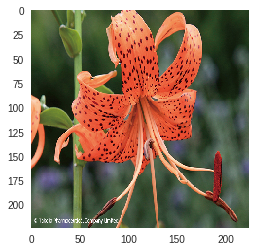

In [0]:
predict_picture("test/lily.jpg")

('Buttercup', 1.0)
('Daffodil', 3.654583e-08)
('Pansy', 2.45053e-09)
('Bluebell', 2.515452e-12)
('Windflower', 1.0315196e-14)


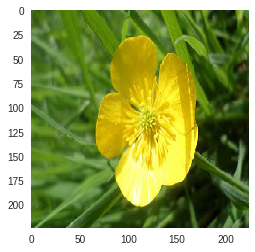

In [0]:
predict_picture("test/butter.jpg")